In [493]:
%matplotlib inline

In [494]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "3"

from pathlib import Path
import torch
from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.encoder import Encoder
from bliss.catalog import TileCatalog
from matplotlib import pyplot as plt

In [495]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path="../../bliss/conf", version_base=None):
    cfg = compose("base_config")

encoder: Encoder = instantiate(cfg.encoder)
encoder.load_state_dict(torch.load("../../data/pretrained_models/clahed_logged_2percent.pt"))
encoder.eval()
encoder.cuda()

simulator = instantiate(cfg.simulator)

torch.set_grad_enabled(False)

## One bright (easily detected) star at various positions

Compare samples with independent and dependent tiling

In [496]:
n = 50
n_sources = torch.zeros(n, 20, 20, dtype=torch.long)
n_sources[:, 10, 10] = 1
n_sources[:, 11, 10] = 1

locs = torch.ones(n, 20, 20, 1, 2) * 0.5
locs[:, 10, 10, 0, 0] = 0.7
locs[:, 11, 10, 0, 0] = 0.3

source_type = torch.zeros(n, 20, 20, 1, 1, dtype=torch.long)

true_catalog_dict = {
    "n_sources": n_sources,
    "source_type": source_type,
    "locs": locs,
    "star_fluxes": torch.ones(n, 20, 20, 1, 5) * 4,
    "galaxy_fluxes": torch.ones(n, 20, 20, 1, 5),
}
true_catalog = TileCatalog(4, true_catalog_dict)

In [497]:
rcfs, rcf_indices = simulator.randomized_image_ids(true_catalog.n_sources.size(0))

In [498]:
image, background, _, _ = simulator.simulate_image(true_catalog, rcfs, rcf_indices)

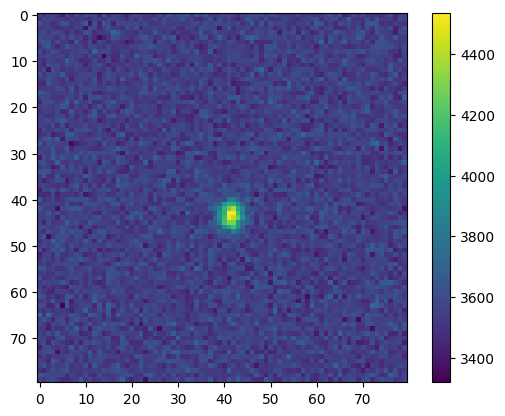

In [499]:
# plot a coadd image
plt.imshow(image[3].sum(0).numpy())
plt.colorbar()

In [500]:
batch = {"images": image.cuda(), "background": background.cuda()}

# now on to comparing joint and marginal

In [501]:
joint_cats = encoder.sample(batch)

In [502]:
marginal_cats = encoder.sample(batch, cat_type="marginal")

In [503]:
joint_cats["n_sources"][:, 9:11, 9].sum(1).float().mean()

tensor(1.7600, device='cuda:0')

In [504]:
marginal_cats["n_sources"][:, 9:11, 9].sum(1).float().mean()

tensor(1.5600, device='cuda:0')

In [505]:
# percent of detections misclassified as galaxies
((marginal_cats["source_type"][:, 9:11, 9, 0, 0] == 1) * marginal_cats["n_sources"][:, 9:11, 9]).sum() / marginal_cats["n_sources"][:, 9:11, 9].sum()

tensor(0.2821, device='cuda:0')

In [506]:
# percent of detections misclassified as galaxies
((joint_cats["source_type"][:, 9:11, 9, 0, 0] == 1) * joint_cats["n_sources"][:, 9:11, 9]).sum() / joint_cats["n_sources"][:, 9:11, 9].sum()

tensor(0.2841, device='cuda:0')

Conclusions from several runs:
 * When both star are 4 pixels apart, joint is slightly likely to detect both. This is surprising because only joint can surpress one light source if has already detected another nearby. But probably 4 pixels is so far that there's minimal ambiguity.
 * When stars get closer, to within 2.4 pixels, there's quite a bit of ambiguity. Many stars are classified as galaxies, and then only one galaxy is detected. The flux needs to increase a lot (to 4 or so, whereas only 0.5 flux is needed for a single detection) before close stars are both usually (>50%) detected.
 * Joint seems to make many fewer (~30% fewer) misclassifications of stars as galaxies.